In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Custom utils
from custom_metrics import compute_metrics, save_metrics
from visual_eval import plot_confusion_matrix, plot_roc_curve

In [2]:
# Paths
PROCESSED_DIR = os.path.abspath(os.path.join("..", "data", "processed"))
PREDICTIONS_DIR = os.path.join(PROCESSED_DIR, "predictions")
FEATURE_IMPORTANCE_DIR = os.path.join(PROCESSED_DIR, "feature_importance")
METRICS_DIR = os.path.join(PROCESSED_DIR, "metrics")
os.makedirs(METRICS_DIR, exist_ok=True)


--- Evaluating Model: LOGREG ---
Evaluation Metrics:
accuracy: 0.8098
precision: 0.7980
recall: 0.8296
f1_score: 0.8135
roc_auc: 0.9021

--- Evaluating Model: RF ---
Evaluation Metrics:
accuracy: 0.8359
precision: 0.8225
recall: 0.8567
f1_score: 0.8393
roc_auc: 0.9215

--- Evaluating Model: XGB ---
Evaluation Metrics:
accuracy: 0.8228
precision: 0.8161
recall: 0.8335
f1_score: 0.8247
roc_auc: 0.9213


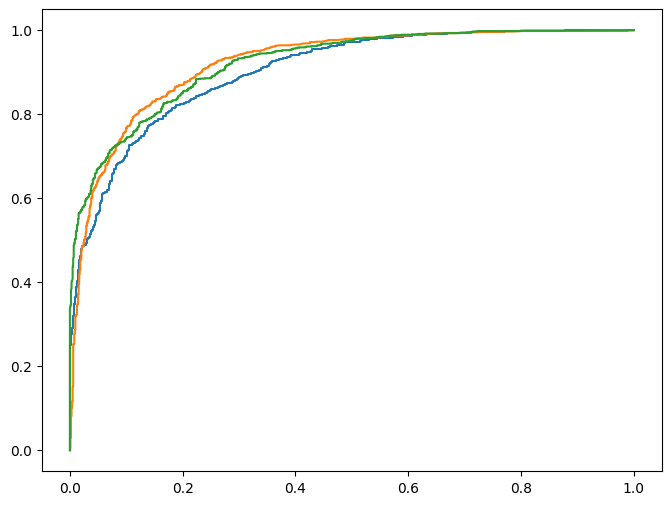

In [3]:
model_types = ["logreg", "rf", "xgb"]

# %% Evaluation results placeholder
model_metrics = {}
roc_curves = {}

# %% Evaluate each model
for model_name in model_types:
    pred_path = os.path.join(PREDICTIONS_DIR, f"predicted_{model_name}.csv")
    
    if not os.path.exists(pred_path):
        print(f"[!] Prediction file missing for model: {model_name}")
        continue

    print(f"\n--- Evaluating Model: {model_name.upper()} ---")
    df = pd.read_csv(pred_path)

    assert {"Churn", "predicted", "predicted_prob"}.issubset(df.columns), \
        f"[!] Missing prediction columns for {model_name}"

    y_true = df["Churn"]
    y_pred = df["predicted"]
    y_prob = df["predicted_prob"]

    # Compute metrics
    metrics = compute_metrics(y_true, y_pred, y_prob)
    model_metrics[model_name] = metrics

    print("Evaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Save classification report
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    report_path = os.path.join(METRICS_DIR, f"classification_report_{model_name}.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=2)

    # Save metrics
    metrics_path = os.path.join(METRICS_DIR, f"metrics_{model_name}.json")
    save_metrics(metrics, metrics_path)

    # Store for ROC curve plot
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_curves[model_name] = (fpr, tpr)

# %% Plot all ROC curves
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    auc = model_metrics[model_name]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name.upper()} (AUC={auc:.2f})")

C:\Users\renit\AppData\Local\Temp\ipykernel_47548\933688699.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


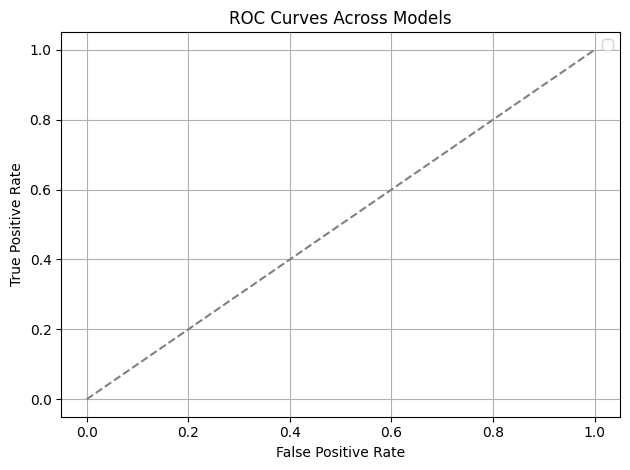

In [4]:
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[✓] Best model by ROC-AUC: RF


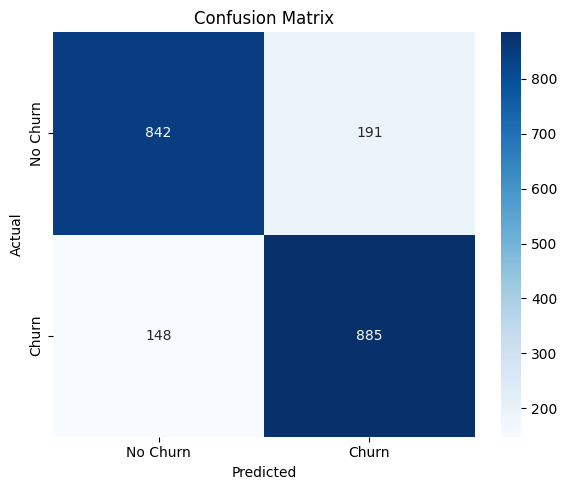

[✓] Saved model summary to model_summary.json


In [5]:
# %% Identify best model by ROC-AUC
best_model = max(model_metrics, key=lambda x: model_metrics[x]["roc_auc"])
print(f"\n[✓] Best model by ROC-AUC: {best_model.upper()}")

# %% Confusion Matrix of best model
df_best = pd.read_csv(os.path.join(PREDICTIONS_DIR, f"predicted_{best_model}.csv"))
plot_confusion_matrix(df_best["Churn"], df_best["predicted"])

# %% Save overall summary
summary = {
    "best_model": best_model,
    "metrics": model_metrics
}
with open(os.path.join(METRICS_DIR, "model_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print(f"[✓] Saved model summary to model_summary.json")